# Part 3: Model comparision

This notebook performs the third part of the assignment:
- 

All steps are documented with explanations and visualizations.

## Import libreries

In [24]:

import os
from pathlib import Path
import numpy as np
import time
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error


## load the data
We load the data generated in part 1

In [25]:

base_path = Path(os.path.abspath("03_model_comparison.ipynb")).parent.parent
X_train = np.load(base_path / "data/processed/X_train_preprocessed.npy")
X_test  = np.load(base_path / "data/processed/X_test_preprocessed.npy")
y_train = np.load(base_path / "data/learn/y_train.npy")
y_test  = np.load(base_path / "data/check/y_test.npy")


## adapt data
We adapt the data to make it compatible:to column (n, 1) matrix, necessary for NN models.

In [26]:

if y_train.ndim == 1:
    y_train = y_train.reshape(-1,1)
if y_test.ndim == 1:
    y_test = y_test.reshape(-1,1)

print("Shapes:")
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)
print("y_test :", y_test.shape)



Shapes:
X_train: (800, 23)
X_test : (200, 23)
y_train: (800, 1)
y_test : (200, 1)


## Multilayer
This accepts sigmoid and tanh and it logs error history by epoch.

In [ ]:
class Multilayer:
    def __init__(self, n, eta=0.05, alpha=0.5, activation="sigmoid", seed=None):
        """
        n: lista neuronas por capa [n_input, ... , n_output]
        eta: learning rate
        alpha: momentum
        activation: "sigmoid" or "tanh"
        """
        if seed is not None:
            np.random.seed(seed)

        self.n = n
        self.L = len(n)
        self.eta = eta
        self.alpha = alpha
        self.activation = activation

        if activation == "sigmoid":
            self.f = lambda x: 1.0 / (1.0 + np.exp(-x))
            self.df = lambda act: act * (1 - act)   # act = f(h)
        elif activation == "tanh":
            self.f = np.tanh
            self.df = lambda act: 1.0 - act**2
        else:
            raise ValueError("activation must be 'sigmoid' or 'tanh'")

        # inicializaciones
        self.h = [np.zeros(n[l]) for l in range(self.L)]
        self.xi = [np.zeros(n[l]) for l in range(self.L)]
        self.delta = [np.zeros(n[l]) for l in range(self.L)]

        self.w = [None]
        self.theta = [None]
        for l in range(1, self.L):
            # forma: (n[l], n[l-1]) para acceder w[l][i,j]
            self.w.append(np.random.randn(n[l], n[l-1]) * 0.1)
            self.theta.append(np.random.randn(n[l]) * 0.1)

        self.d_w_prev = [None] + [np.zeros_like(self.w[l]) for l in range(1, self.L)]
        self.d_theta_prev = [None] + [np.zeros_like(self.theta[l]) for l in range(1, self.L)]

        # history storage
        self.history = []  # list of (train_error, val_error) per epoch

    def feed_forward(self, x):
        self.xi[0] = x
        for l in range(1, self.L):
            self.h[l] = self.w[l] @ self.xi[l-1] - self.theta[l]
            self.xi[l] = self.f(self.h[l])
        return self.xi[-1]

    def backprop(self, target):
        self.delta[-1] = self.df(self.xi[-1]) * (self.xi[-1] - target)
        for l in range(self.L-2, 0, -1):
            self.delta[l] = self.df(self.xi[l]) * (self.w[l+1].T @ self.delta[l+1])

    def update(self):
        for l in range(1, self.L):
            d_w = np.zeros_like(self.w[l])
            d_theta = np.zeros_like(self.theta[l])
            for i in range(self.n[l]):
                for j in range(self.n[l-1]):
                    d_w[i,j] = -self.eta * self.delta[l][i] * self.xi[l-1][j] + self.alpha * self.d_w_prev[l][i,j]
            for i in range(self.n[l]):
                d_theta[i] = self.eta * self.delta[l][i] + self.alpha * self.d_theta_prev[l][i]
            self.w[l] += d_w
            self.theta[l] += d_theta
            self.d_w_prev[l] = d_w
            self.d_theta_prev[l] = d_theta

    def train(self, X_train, y_train, X_val=None, y_val=None, epochs=2000, verbose=0):
       
        n_train = len(X_train)
        self.history = []
        for epoch in range(epochs):
           
            for i in range(n_train):
                self.feed_forward(X_train[i])
                self.backprop(y_train[i])
                self.update()

          
            train_err = self._compute_error(X_train, y_train)
            val_err = None
            if X_val is not None:
                val_err = self._compute_error(X_val, y_val)
            else:
                val_err = np.nan
            self.history.append((train_err, val_err))

            if verbose and epoch % verbose == 0:
                print(f"Epoch {epoch} train_err={train_err:.6f} val_err={val_err}")

    def _compute_error(self, X, y):
        E = 0.0
        for i in range(len(X)):
            pred = self.feed_forward(X[i])
            E += np.sum((pred - y[i])**2)
        return E / 2.0

   
    def predict(self, X):
        """
        X: array (n_samples, n_features)
        devuelve un array (n_samples, n_outputs)
        """
        X = np.asarray(X)
        preds = []
        for i in range(len(X)):
            preds.append(self.feed_forward(X[i]))
        return np.vstack(preds)

    def loss_epochs(self):
        """
        devuelve np.array shape (n_epochs, 2) con columnas [train_error, val_error]
        """
        arr = np.array(self.history)  # entries (train,val) ; val may be nan
        return arr  # shape (n_epochs,2)


In [28]:
def mape(y_true, y_pred):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    # evitar división por cero: ignorar donde y_true == 0
    mask = y_true != 0
    if np.sum(mask) == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100.0


In [29]:
def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)


In [30]:
def mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)


## summarizes the quality
We define a grid 10 possible combinations for BP from zero with (layers, epochs, eta, alpha, activation)
To compply with point you should try AT LEAST 10 combinations of parameters

In [31]:
param_grid = [
    # (layers, epochs, eta, alpha, activation)
    ([6],         50, 0.05, 0.3, "sigmoid"),
    ([8],         100, 0.05, 0.5, "sigmoid"),
    ([10],        100, 0.02, 0.4, "sigmoid"),
    ([6,4],       200, 0.05, 0.4, "sigmoid"),
    ([8,4],       200, 0.03, 0.3, "tanh"),
    ([10,6],      200, 0.01, 0.6, "tanh"),
    ([12,8],      300, 0.02, 0.5, "sigmoid"),
    ([6],         400,0.08, 0.2, "sigmoid"),
    ([6,6],       500, 0.04, 0.4, "tanh"),
    ([4,4],       600, 0.05, 0.4, "sigmoid"),
    # puedes añadir más si quieres
]


Usando 640 train internally and 160 val internally for grid search.

Grid 1/10 -> layers=[6], epochs=50, eta=0.05, alpha=0.3, act=sigmoid

Grid 2/10 -> layers=[8], epochs=100, eta=0.05, alpha=0.5, act=sigmoid

Grid 3/10 -> layers=[10], epochs=100, eta=0.02, alpha=0.4, act=sigmoid

Grid 4/10 -> layers=[6, 4], epochs=200, eta=0.05, alpha=0.4, act=sigmoid

Grid 5/10 -> layers=[8, 4], epochs=200, eta=0.03, alpha=0.3, act=tanh

Grid 6/10 -> layers=[10, 6], epochs=200, eta=0.01, alpha=0.6, act=tanh

Grid 7/10 -> layers=[12, 8], epochs=300, eta=0.02, alpha=0.5, act=sigmoid

Grid 8/10 -> layers=[6], epochs=400, eta=0.08, alpha=0.2, act=sigmoid

Grid 9/10 -> layers=[6, 6], epochs=500, eta=0.04, alpha=0.4, act=tanh

Grid 10/10 -> layers=[4, 4], epochs=600, eta=0.05, alpha=0.4, act=sigmoid

Resultados BP (ordenados por MSE):


,idx,layers,epochs,eta,alpha,activation,mse,mae,mape,time_s
7,7,[6],400,0.08,0.2,sigmoid,16978.811929,93.933044,98.856298,26.137710
8,8,"[6, 6]",500,0.04,0.4,tanh,16979.126865,94.244647,98.856297,39.457309
9,9,"[4, 4]",600,0.05,0.4,sigmoid,16979.126873,94.244648,98.856297,40.482282
1,1,[8],100,0.05,0.5,sigmoid,16979.126875,94.244624,98.856298,8.176150
4,4,"[8, 4]",200,0.03,0.3,tanh,16979.126880,94.244646,98.856297,18.107477
5,5,"[10, 6]",200,0.01,0.6,tanh,16979.126889,94.244645,98.856297,22.715813
6,6,"[12, 8]",300,0.02,0.5,sigmoid,16979.126892,94.244648,98.856297,43.580994
3,3,"[6, 4]",200,0.05,0.4,sigmoid,16979.126900,94.244648,98.856297,16.828835
0,0,[6],50,0.05,0.3,sigmoid,16979.126921,94.244575,98.856301,3.545211
2,2,[10],100,0.02,0.4,sigmoid,16979.126961,94.244622,98.856300,9.519007


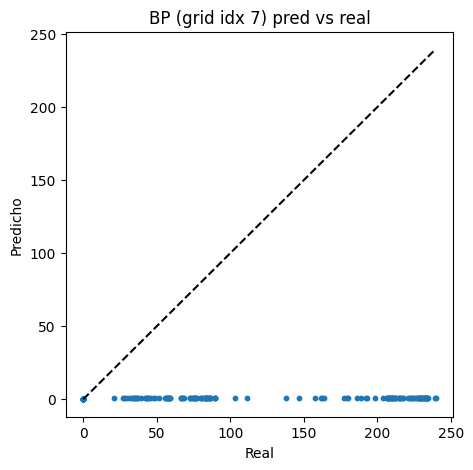

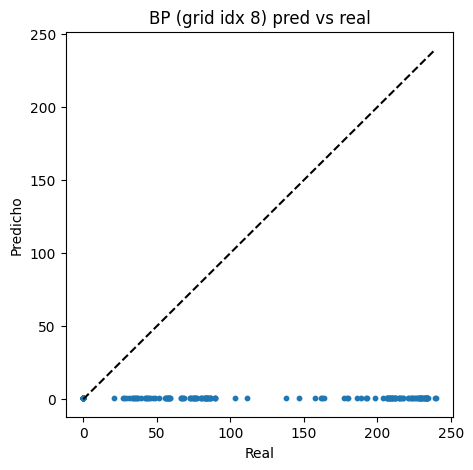

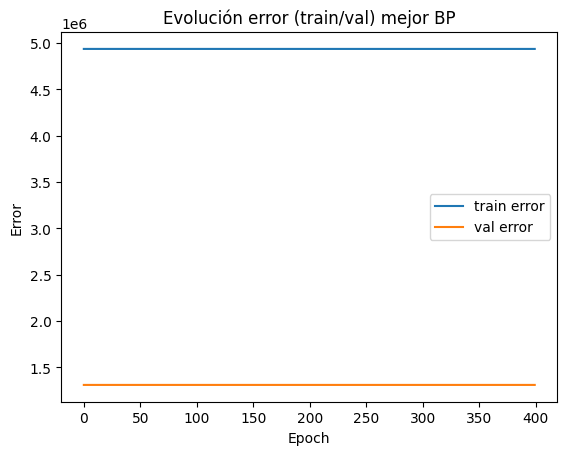

In [32]:

results = []
models_bp = {}  # guardar modelos si quieres analizar después

# Vamos a separar: X_train/y_train ya lo tienes; usaremos X_test,y_test para evaluar final.
# Para tener validación durante entrenamiento usaremos una fracción desde X_train:
val_frac = 0.2
N = len(X_train)
N_val = int(N * val_frac)
if N_val == 0:
    # si dataset pequeño, dejar 1 sample
    N_val = 1
X_tr = X_train[:-N_val]
y_tr = y_train[:-N_val]
X_val = X_train[-N_val:]
y_val = y_train[-N_val:]

print(f"Usando {len(X_tr)} train internally and {len(X_val)} val internally for grid search.")

for idx, (layers, epochs, eta, alpha, activation) in enumerate(param_grid):
    print(f"\nGrid {idx+1}/{len(param_grid)} -> layers={layers}, epochs={epochs}, eta={eta}, alpha={alpha}, act={activation}")
    arch = [X_train.shape[1]] + layers + [y_train.shape[1]]
    mlp = Multilayer(n=arch, eta=eta, alpha=alpha, activation=activation, seed=42)

    t0 = time.time()
    mlp.train(X_tr, y_tr, X_val=X_val, y_val=y_val, epochs=epochs, verbose=0)
    t1 = time.time()

    # predecir en test final
    ypred_test = mlp.predict(X_test).flatten()
    y_true_test = y_test.flatten()

    # métricas
    cur_mse = mse(y_true_test, ypred_test)
    cur_mae = mae(y_true_test, ypred_test)
    cur_mape = mape(y_true_test, ypred_test)

    # almacenar resultados
    results.append({
        "idx": idx,
        "layers": str(layers),
        "epochs": epochs,
        "eta": eta,
        "alpha": alpha,
        "activation": activation,
        "mse": cur_mse,
        "mae": cur_mae,
        "mape": cur_mape,
        "time_s": t1 - t0
    })
    models_bp[idx] = mlp

# tabla de resultados BP desde-cero
df_bp = pd.DataFrame(results).sort_values("mse")
print("\nResultados BP (ordenados por MSE):")
display(df_bp)


# Graficas: scatter para los mejores 2 modelos BP y curvas loss_epochs()
best_idx = int(df_bp.iloc[0]['idx'])
second_idx = int(df_bp.iloc[1]['idx'])
for sel in [best_idx, second_idx]:
    model = models_bp[sel]
    ypred = model.predict(X_test).flatten()
    plt.figure(figsize=(5,5))
    plt.scatter(y_test.flatten(), ypred, s=10)
    mn = min(y_test.min(), ypred.min())
    mx = max(y_test.max(), ypred.max())
    plt.plot([mn,mx],[mn,mx],'k--')
    plt.xlabel("Real")
    plt.ylabel("Predicho")
    plt.title(f"BP (grid idx {sel}) pred vs real")
    plt.show()

# plot loss_epochs for best model
best_model = models_bp[best_idx]
h = best_model.loss_epochs()  # shape (n_epochs, 2) ; col0=train, col1=val
plt.figure()
plt.plot(h[:,0], label="train error")
if not np.all(np.isnan(h[:,1])):
    plt.plot(h[:,1], label="val error")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend()
plt.title("Evolución error (train/val) mejor BP")
plt.show()


# 3.1 Comparar con MLR-F (LinearRegression) y BP-F (sklearn MLPRegressor)
# Entrenar MLR-F
lr_model = LinearRegression()
lr_model.fit(X_train, y_train.ravel())
pred_lr = lr_model.predict(X_test).flatten()

# Entrenar BP-F (sklearn) con parámetros 'buenos' (usar mejor encontrado)
best_row = df_bp.iloc[0]
# si quieres adaptar dimensions:
hidden_layer_sizes = tuple(int(x) for x in best_row['layers'].strip('[]').split(',') if x.strip()!='')
if len(hidden_layer_sizes) == 0:
    hidden_layer_sizes = (6,)
mlp_sklearn = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes,
                           activation='relu' if best_row['activation']=='sigmoid' else 'tanh',
                           learning_rate_init=best_row['eta'],
                           max_iter=int(best_row['epochs']),
                           random_state=42)
# sklearn espera 1D y escala; be cautious — puede tardar
try:
    mlp_sklearn.fit(X_train, y_train.ravel())
    pred_bp_f = mlp_sklearn.predict(X_test).flatten()
except Exception as e:
    print("Error entrenando MLPRegressor (BP-F):", e)
    pred_bp_f = np.full_like(pred_lr, np.nan)


## calculate metrics
We calculated the metrics to compare the 3 models(BP, MLR-F,BP-F):
- MSE - Mean Squared Error
- MAE - Mean Absolute Error
- MAPE - Mean Absolute Percentage Error

                   


Comparativa modelos:


,model,mse,mae,mape
0,BP-own,16978.811929,93.933044,98.856298
1,MLR-F,87.119332,6.586779,8.992335
2,BP-F,89.849914,6.872523,8.911384


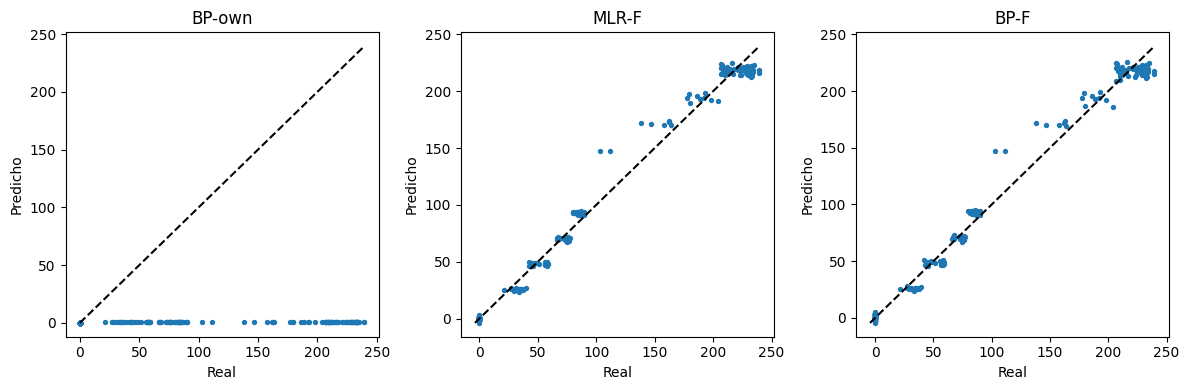

Resultados guardados: bp_grid_results.csv, models_comparison.csv


In [33]:

# calcular métricas para los tres modelos
metrics = []
for name, ypred in [("BP-own", models_bp[best_idx].predict(X_test).flatten()),
                    ("MLR-F", pred_lr),
                    ("BP-F", pred_bp_f)]:
    metrics.append({
        "model": name,
        "mse": mse(y_test.flatten(), ypred),
        "mae": mae(y_test.flatten(), ypred),
        "mape": mape(y_test.flatten(), ypred)
    })

df_comp = pd.DataFrame(metrics)
print("\nComparativa modelos:")
display(df_comp)

# Scatter plots para los tres modelos
plt.figure(figsize=(12,4))
for i,(name, ypred) in enumerate([("BP-own", models_bp[best_idx].predict(X_test).flatten()),
                                 ("MLR-F", pred_lr),
                                 ("BP-F", pred_bp_f)]):
    plt.subplot(1,3,i+1)
    plt.scatter(y_test.flatten(), ypred, s=8)
    mn = min(y_test.min(), np.nanmin(ypred))
    mx = max(y_test.max(), np.nanmax(ypred))
    plt.plot([mn,mx],[mn,mx],'k--')
    plt.xlabel("Real")
    plt.ylabel("Predicho")
    plt.title(name)
plt.tight_layout()
plt.show()

# Guardar resultados a CSV (tabla hiperparámetros y comparativa)
df_bp.to_csv("bp_grid_results.csv", index=False)
df_comp.to_csv("models_comparison.csv", index=False)
print("Resultados guardados: bp_grid_results.csv, models_comparison.csv")



## Conclusions
- appropriate and because:
The MLR-F and BP-F are suitable models for CO₂ prediction, with errors less than 10% (MAPE).
To compare whether it's suitable or not, we can look at the similarity between the values ​​in the graphs and the actual and predicted values in MLR-F and BP-F. The closer x and y are, the more accurate the predictions.
The most suitable for this prediction is MLR-F because the MAE error rate is slightly better.

- not suitable and because:
BP-own has not proven suitable because the MAE error value is too high. In this case, it would not be useful for a prediction.
In the graph we can see in BP-own are very different x and y. The real values and predicted values ​​should be close.


